In [ ]:
import polars as pl
import numpy as np
import wave


def read_parquet(filename: str) -> pl.DataFrame:
    df1 = pl.read_parquet(f"data/{filename}")
    df1 = df1.with_row_count().with_columns(
        (pl.col("row_nr").cast(pl.Float32) / 20000.0 * 1000000000.0).cast(pl.Time))
    df1 = df1.rename({"row_nr": "time"})
    return df1


def convert_series_to_wav(series: pl.Series, path: str):
    diff = (series.max() - series.min()) / 2.0
    normalized_data = (series / diff * 20000).cast(pl.Int16)
    bytes = normalized_data.to_numpy().tobytes()
    with wave.open(path, 'w') as wav_file:
        wav_file.setnchannels(1)  # mono
        wav_file.setsampwidth(2)  # 2 bytes = 16 bit
        wav_file.setframerate(20000)  # common sample rate
        wav_file.setnframes(len(normalized_data))
        wav_file.writeframes(bytes)


files = [
    ("d4", "D0400001.parquet", "CH6_akustik"),
    ("d6", "D0600001.parquet", "CH6_akustik"),
    ("d8", "D0800001.parquet", "CH6_akustik"),
    ("v2", "V2_00001.parquet", "CH4_akustik"),
    ("v6", "V6_00001.parquet", "CH4_akustik"),
    ("v10", "V10_0001.parquet", "CH4_akustik"),
    ("v17", "V17_0001.parquet", "CH4_akustik"),
    ("v20", "V20_0001.parquet", "CH4_akustik"),
    ("v24", "V24_0001.parquet", "CH4_akustik"),
    ("v25", "V25a_001.parquet", "CH4_akustik")
]

for (name, parquet_path, sound_channel) in files:
    df = read_parquet(parquet_path)
    convert_series_to_wav(df[sound_channel], f"data/{name}.wav")
    exec(f"{name} = df")

# define the dataframes again because pylance too stupid to pick up the exec above
d4: pl.DataFrame = d4
d6: pl.DataFrame = d6
d8: pl.DataFrame = d8
v2: pl.DataFrame = v2
v6: pl.DataFrame = v6
v10: pl.DataFrame = v10
v17: pl.DataFrame = v17
v20: pl.DataFrame = v20
v24: pl.DataFrame = v24
v25: pl.DataFrame = v25

look at all the header files:

```
| df  | filename           | comments                                                                   | columns                                                                                  |
| --- | ------------------ | -------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- |
| d4  | "D0400001.parquet" | vc=111m/min, f=0.231mm, Dämpfer 1240 mm von Einspannung, DiffDruck: 12 bar | CH1_Moment, CH2_Kraft, CH3_Biegemo, CH4_SyncSig, CH5_a3_BOZA, CH6_akustik, CH7_a4_Bohrst |
| d6  | "D0600001.parquet" | vc=120m/min, f=0.185mm, Dämpfer 1240 mm von Einspannung, DiffDruck: 12 bar | CH1_Moment, CH2_Kraft, CH3_Biegemo, CH4_SyncSig, CH5_a3_BOZA, CH6_akustik, CH7_a4_Bohrst |
| d8  | "D0800001.parquet" | vc=90m/min, f=0.250mm, Dämpfer 1240 mm von Einspannung, DiffDruck: 12 bar  | CH1_Moment, CH2_Kraft, CH3_Biegemo, CH4_SyncSig, CH5_a3_BOZA, CH6_akustik, CH7_a4_Bohrst |
| v2  | "V2_00001.parquet" | vc=120 mm/min, f=0.185                                                     | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v6  | "V6_00001.parquet" | Schneiden 2, v_c=111 m/min, f=0.231 mm, V_oel=371 l/min                    | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v10 | "V10_0001.parquet" | Schneiden 4, v_c=111 m/min, f=0.231 mm, V_oel=229 l/min                    | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v17 | "V17_0001.parquet" | Schneiden 6, v_c=120 m/min, f=0.185 mm, V_oel=300 l/min                    | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v20 | "V20_0001.parquet" | Schneiden 8, v_c=90 m/min, f=0.250 mm, V_oel=300 l/min                     | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v24 | "V24_0001.parquet" | Schneiden 12, v_c=120 m/min, f=0.185 mm, V_oel=300 l/min                   | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
| v25 | "V25a_001.parquet" | Schneiden 13, v_c=120 m/min, f=0.185 mm, V_oel=300 l/min                   | CH1_Moment, CH2_Kraft, CH3_SyncSig, CH4_akustik, CH5_a1_WSAS, CH6_a2_WSAF, CH7_a3_BOZA   |
```


now listen to audio manually to see if we can hear the chatter coming at some point. Then note these values down:

```
d4, d6, d8 had no chatter.

v2:  0:10 normal   3:20.25  chatter                                                     4:24 end
v6                 0:47.40  first chatter                         2:16 second chatter   4:13 end
v10                0:47.35  first chatter                         1:31 second chatter   4:12 end
v17                0:34.50  first chatter                         0:45 second cahtter   4:30 end
v20                0:52.50  first chatter   1:36 almost normal    1:47 second chatter   4:47 end
v24                0:21.60  first chatter                         1:04 second chatter   4:18 end
v25                1:58.50  chatter                                                     4:20 end
```


In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


def plot_acf_for_region(df: pl.DataFrame, column: str, start_sec: float, end_sec: float, nlags: int = 30, save_path: str = None, title: str = None):
    acf = sm.tsa.stattools.acf(
        df[column][int(20000*start_sec):int(20000*end_sec)], nlags=nlags)
    plt.stem(acf)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    if title is not None:
        plt.title(title)
    plt.show()
    if save_path is not None:
        plt.savefig(save_path)


v_columns = ["CH1_Moment", "CH2_Kraft", "CH3_SyncSig",
             "CH4_akustik", "CH5_a1_WSAS", "CH6_a2_WSAF", "CH7_a3_BOZA"]
# for each of the relevant columns plot the acf druing chattering and non-chattering
df_and_regions = [(v2, "v2", (10, 200), (200, 264), None),
                  (v6, "v6", (10, 47), (47, 136), (91, 253)),
                  (v10, "v10", (10, 47), (47, 91), (91, 252)),
                  (v17, "v17", (10, 34), (34, 45), (45, 270)),
                  (v20, "v20", (10, 52), (52, 136), (147, 287)),
                  (v24, "v24", (10, 21.6), (21.6, 64), (64, 258)),
                  (v25, "v25", (10, 118), (118, 260), None),
                                                      ]
for (df, name, non_chattering_region, chattering_region, chattering_region2) in df_and_regions:
    (non_start, non_end) = non_chattering_region
    (chattering_start, chattering_end) = chattering_region
    for column in v_columns:
        plot_acf_for_region(df, column, non_start, non_end,
                            title=f"{name}_{column}_non_chattering")  # todo: savepath
        plot_acf_for_region(df, column, chattering_start, chattering_end,
                            title=f"{name}_{column}_chattering")  # todo: savepath
        if chattering_region2 is not None:
            (chattering_start2, chattering_end2) = chattering_region2
            plot_acf_for_region(df, column, chattering_start2, chattering_end2,
                                title=f"{name}_{column}_chattering_region_2")  # todo: savepath

    #
    # if chattering_region2 is not None:
    #     (chattering_start2, chattering_end2) = chattering_region2

# plot_acf_for_region(v6, "CH4_akustik", 20, 30)
# plot_acf_for_region(v6, "CH4_akustik", 50, 100)

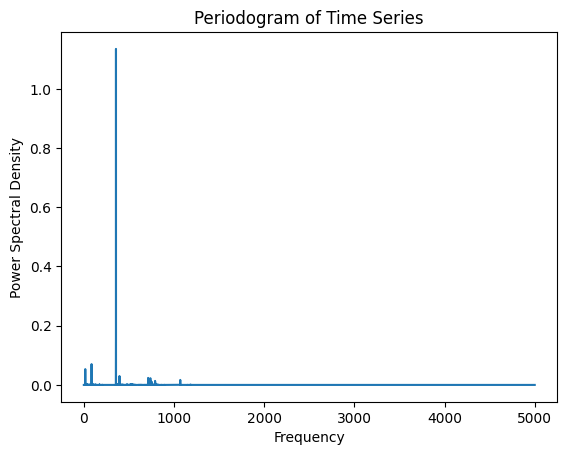

In [36]:
from scipy import signal

frequencies, spectrum = signal.periodogram(v2["CH4_akustik"][20000*200 : 20000*260], 10000)

# Plot the periodogram
plt.plot(frequencies, spectrum)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram of Time Series')
plt.show()